In [200]:
# !pip install scipy
# !pip install tqdm
# !pip install matplotlib
# !pip install numpy
# from tqdm import tqdm
# import scipy
# import matplotlib.pyplot as plt
# import numpy as np
# from scipy.sparse import csr_matrix

## I. X-ray tomography

In [201]:
N = 8100
M = 16200
lambda_ = 0.13
delta = 0.02

G = scipy.io.loadmat('data/G.mat')['G']
G = csr_matrix(G)
H = scipy.io.loadmat('data/H.mat')['H']
H = csr_matrix(H)

x_bar = scipy.io.loadmat('data/x.mat')['x'].reshape(N)
w = np.random.randn(M)
y = H @ x_bar + w

x_bar_sinogram = x_bar.reshape((90, 90), order='F')
y_sinogram = y.reshape((90, 180), order='F')

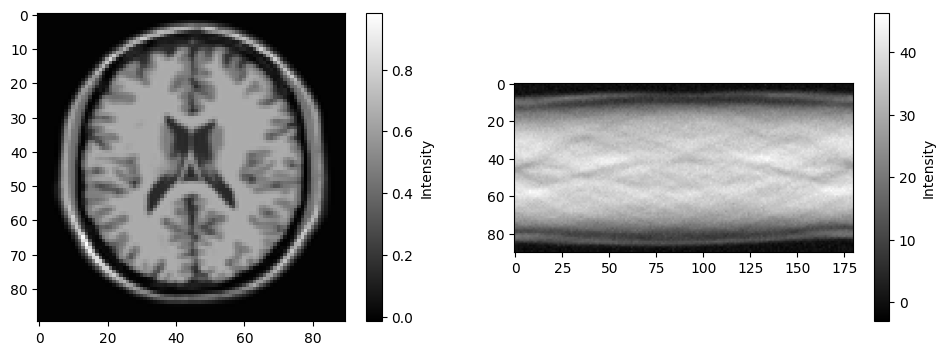

In [202]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
# axs[0].imshow(x_bar_sinogram, cmap='gray')
fig.colorbar(axs[0].imshow(x_bar_sinogram, cmap='gray'), ax=axs[0], label='Intensity')

# axs[1].imshow(y_sinogram, cmap='gray')
fig.colorbar(axs[1].imshow(y_sinogram, cmap='gray'), ax=axs[1], label='Intensity')

## II. Optimization problem

In [203]:
def phi(x: np.ndarray) -> float:
    def phi_scalar(x: float) -> float:
        return np.sqrt(1 + x**2/delta**2)
    phi_vect = np.vectorize(phi_scalar)
    return phi_vect(x)

def phi_prime(x: np.ndarray) -> np.ndarray:
    def phi_prime_scalar(x: float) -> float:
        return x/((delta**2)*phi(x))
    phi_prime_vect = np.vectorize(phi_prime_scalar)
    return phi_prime_vect(x)

def phi_second(x: np.ndarray) -> np.ndarray:
    def phi_second_scalar(x: float) -> float:
        return (phi(x) - x * phi_prime(x))/(delta**2 * phi(x)**2)
    phi_second_vect = np.vectorize(phi_second_scalar)
    return phi_second_vect(x)

def r(x: np.ndarray) -> float:
    return np.sum(phi(G @ x))

def grad_r(x: np.ndarray) -> np.ndarray:
    return G.T @ phi_prime(G @ x)

def hessian_r(x: np.ndarray) -> np.ndarray:
    return G.T @ np.diag(phi_second(G @ x).flatten()) @ G        

def f(x: np.ndarray, H: np.ndarray, y:np.array) -> float:
    return 0.5 * np.linalg.norm(H @ x - y)**2 + lambda_ * r(x)

def grad_f(x: np.ndarray, H: np.ndarray, y:np.array) -> np.ndarray:
    return H.T @ (H @ x - y) + lambda_ * grad_r(x)

def hessian_f(x: np.ndarray, H: np.ndarray, y:np.array) -> np.ndarray:
    return H.T @ H + lambda_ * hessian_r(x)

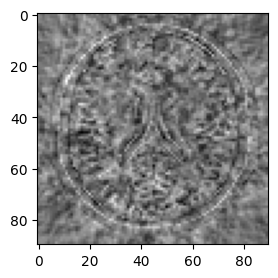

In [204]:
grad_test = grad_f(x_bar, H, y)
plt.figure(figsize=(3,3))
plt.imshow(grad_test.reshape((90, 90), order='F'), cmap='gray')

### Q3

## Optimization algorithms

In [205]:
x0 = np.zeros(N)


### I. Gradient Descent

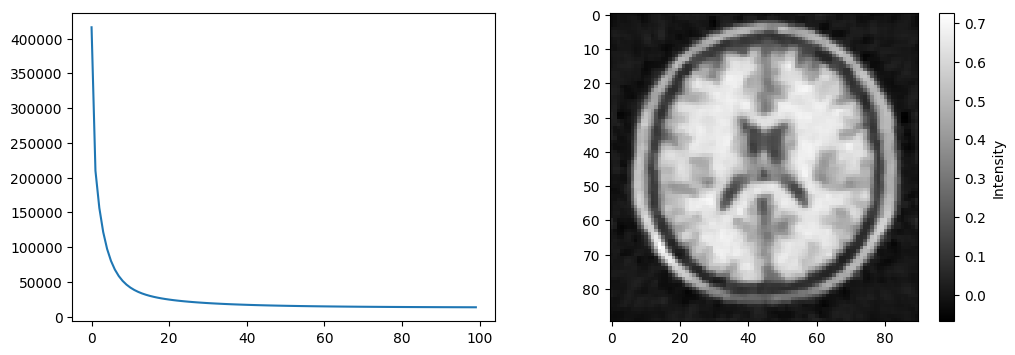

In [ ]:
def grad_desc(x0: np.ndarray, eta: float, lambda_: float, delta: float, max_iter: int):
    x_gd = x0
    loss_history = []
    x_history = []
    for i in range(max_iter):
        x_gd = x_gd - eta*grad_f(x_gd, H, y) 
        loss_history.append(f(x_gd, H, y))
        x_history.append(x_gd)
    return x_gd, loss_history, x_history

eta = 1/L
max_iter = 50
x_gd, loss_history, x_history = grad_desc(x0, eta, lambda_, delta, max_iter)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(loss_history)
fig.colorbar(axs[1].imshow(x_gd.reshape((90,90), order='F'), cmap='gray'), ax=axs[1], label='Intensity')

### MM quadratic algorithm

In [208]:
from scipy.sparse import diags
from scipy.sparse.linalg import LinearOperator, cg, eigsh, bicg


def A(x: np.ndarray) -> np.ndarray:
    hessian = hessian_f(x, H, y)
    sparse_hessian = csr_matrix(hessian)
    d, p = eigsh(sparse_hessian, k=1)

    d = np.full(N, d[0] + 1)      # check that 1 is a good margin
    curvature = diags(d).tocsc()  # Might work?

    def matvec(v):
        return curvature @ v
    
    def rmatvec(v):
        return curvature.T @ v
    
    A = LinearOperator((N, N), matvec=matvec, rmatvec=rmatvec)

    return A


def mm_algorithm(x0: np.ndarray, theta: float, max_iter: int): #theta cst over the iterations for now
    x_mm = x0
    loss_history = []
    x_history = []
    for i in tqdm(range(max_iter)):
        # Solve iteratively the linear system
        grad_mm = grad_f(x_mm, H, y)
        A_mm = A(x_mm)
        v, info = bicg(A_mm, grad_mm)
        if info != 0:
            raise ValueError ("CG did not converge")
        
        x_mm = x_mm - theta*v 
        x_history.append(x_mm)
        loss_history.append(f(x_mm, H, y))
    return x_mm, loss_history, x_history

theta = 0.1
max_iter = 5
x_mm, loss_history_mm, x_history_mm = mm_algorithm(x0, theta, max_iter)

100%|██████████| 5/5 [00:33<00:00,  6.60s/it]


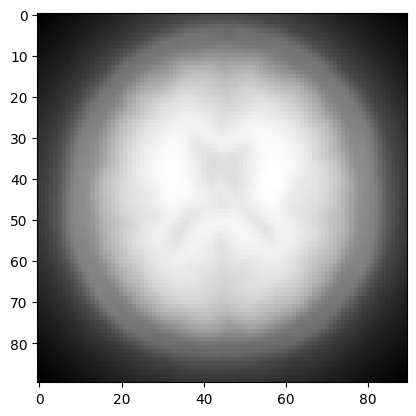

In [209]:
# plt.plot(loss_history_mm)
plt.imshow(x_mm.reshape((90,90), order='F'), cmap='gray')

In [211]:
def mg_algo(x0: np.ndarray, max_iter: int) -> np.ndarray:
    x3mg = x0
    loss_history = []
    x_history = []
    D = np.zeros((N, 2))
    for i in tqdm(range(max_iter)):
        D[:,0] = -grad_f(x3mg, H, y)
        A3mg = A(x3mg)
        u = -np.linalg.pinv(D.T @ A3mg @ D) @ (D.T @ grad_f(x3mg, H, y))
        x3mg += D @ u
        D[:,1] = D @ u
        loss_history.append(f(x3mg, H, y))
        x_history.append(x3mg)
    return x3mg, loss_history, x_history

max_iter = 5
x_3mg, loss_history_3mg, x_history_3mg = mg_algo(x0, max_iter)

100%|██████████| 5/5 [00:32<00:00,  6.52s/it]


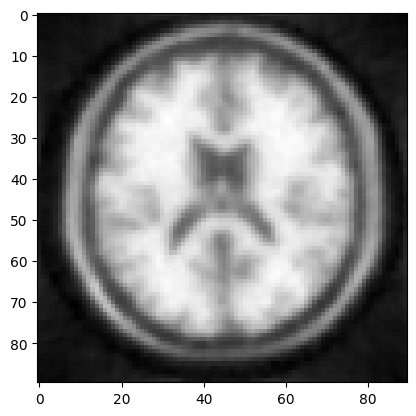

In [184]:
# plt.plot(loss_history_3mg)
plt.imshow(x_3mg.reshape((90,90), order='F'), cmap='gray')

### IV. Block coordinate MM quadratic algorithm

In [ ]:
def fj(x: np.ndarray, j: int, J:int) -> float:
    indices = range(Nj*(j-1) + 1, Nj*j + 1)
    Hj = H[indices, :] 
    yj = y[indices]
    xj = x[indices]
    return f(xj, Hj, yj)


Nj = 2
def block_mm(x0: np.array, max_iter: int) -> np.array:
    